# Nonlinear Regression
G. Richards (2016,2018), based on materials from Connolly (especially) and Ivezic.

Up to now we have been fitting using *linear* models.  Before moving on to *non-linear* models, we'll look at local linear fitting.  Kernel Regression (or Nadaraya-Watson) was one such method.  

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Locally Linear Regression (LOWESS or LOESS)

In [Local Linear Regression](https://en.wikipedia.org/wiki/Local_regression) we assume that the regression function at any point can
be approximated by a [Taylor series expansion](https://www.mathsisfun.com/algebra/taylor-series.html).  If we truncated the Taylor series at the first term, then this would be the same as Nadaraya-Watson.

This is similar to Kernel regression, except that we fit the local regression to the weighted points

$$\sum_{i=1}^N  K\left(\frac{||x-x_i||}{h}\right) \left( y_i - w(x) \, x_i \right)^2.$$

One version of this called LOWESS (locally weighted scatter plot smoothing) uses the "tricubic" Kernel:

$$K(x_i,x) = \left ( 1 - \left ( \frac{|x - x_i |}h{}\right )^3 \right )^3.$$

However, the book isn't really very clear on this (or LOESS, which might stand for LOcal regrESSion) and it doesn't appear that this is implemented in either astroML or Scikit-Learn.  So, we are going to move on--just realize that there algorithms that are intermediate between linear and nonlinear.


## Non-linear Regression

Often we can make our non-linear data linear (e.g., by taking the log), but that has its own set of complications (e.g., asymmetric error bars).  So we should also consider non-linear regression.

If we know the theoretical form of the model, then one option is to use MCMC techniques to sample the parameter space and find the optimal model parameters.

An alternate approach is to use the Levenberg-Marquardt (LM) algorithm to optimize the maximum likelihood estimation. [Numerical Recipes](http://numerical.recipes/) is an excellent resource for more information about LM.  I can't really emphasize enough how ubiquitous LM is, you really should learn how it works in detail.

For now let's leave it as these few words of explanation (with links for further study).
LM searches through a combination of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and [Gauss-Newton](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) optimization. If we can express our
regression function as a Taylor series expansion then, to first order,
then we can write

$$f(x_i|\theta) = f(x_i|\theta_0) + J d\theta.$$

Here $\theta_0$ is an initial guess for the regression parameters,
$J$ is the Jacobian about this point ($J=\partial f(x_i|\theta)/ \partial
 \theta$), and $d\theta$ is a perturbation in the regression
parameters. 

LM minimizes the sum of square errors,

$$\sum_i [y_i- f(x_i|\theta_0) - J_i d\theta]^2,$$

for a perturbation $d\theta$. This minimization results in an update relation for
$d\theta$ given by

$$(J^TC^{-1}J + \lambda\ {\rm diag}(J^TC^{-1}J) )\,d\theta = J^TC^{-1}(Y-f(X|\theta)),$$

where $\lambda$ term acts as a damping parameter.  If $\lambda$ is small, then the relation approximates a Gauss-Newton method (i.e., it minimizes the parameters assuming the function is quadratic). If $\lambda$ is large the perturbation $d\theta$ follows the direction of
steepest descent. The diag$(J^TC^{-1}J)$ term is what makes it different from Ridge Regression and it ensures that the update of $d\theta$ is largest along directions where the gradient is smallest (which
improves convergence).

This is an iterative process which ceases when the change in likelihood values reaches a predetermined limit.

Don't worry if that doesn't make any sense.  I'm going to use this discussion of gradient descent as an excuse to introduce artificial neural networks at the end of this lecture, where I'll give you some resources that should help clarify the situation.

In SciPy [`scipy.optimize.leastsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) implements the LM algorithm.
Here is an example call to estimate the first 6 terms of the Taylor series for $y=\sin x$.

In [1]:
import numpy as np
from scipy import optimize
x = np.linspace(-3,3,100) # 100 values between -3 and 3

def taylor_err(a, x, f):
    p = np.arange(len(a))[:, None]
    return f(x) - np.dot(a,x**p)

a_start = np.zeros(6) # starting guess
a_best, flat = optimize.leastsq(taylor_err, a_start, args=(x,np.sin))

In [2]:
print(a_best) #Print coefficients of the Taylor series exapansion.  Do they make sense?

[-7.55027807e-17  9.90094836e-01  2.04199756e-16 -1.56677082e-01
 -3.74253880e-17  5.80542809e-03]


## Outliers

To be honest, I'm not at all certain why the book brings up outliers at this particular point.  However, we need to talk about outliers sometime.  As with other things today, we'll skip over a lot and do just enough to give you a feel for what can be done.

We'll use what we learned from Chapter 5 to adopt a Bayesian approach to identifying outliers and account for them in our fit.

Let's assume the data are drawn from two Gaussians distributions (one for the function and the other for the outliers)

$$\begin{eqnarray}
&  p(\{y_i\}|\{x_i\}, \{\sigma_i\}, \theta_0, \theta_1, \mu_b, V_b, p_b)
  \propto \nonumber\\
&  \prod_{i=1}^{N} \bigg[
    \frac{1-p_b}{\sqrt{2\pi\sigma_i^2}}
      \exp\left(-\frac{(y_i - \theta_1 x_i - \theta_0)^2}
               {2 \sigma_i^2}\right)
    + \frac{p_b}{\sqrt{2\pi(V_b + \sigma_i^2)}}
    \exp\left(-\frac{(y_i - \mu_b)^2}{2(V_b + \sigma_i^2)}\right)
    \bigg].
\end{eqnarray}
$$

$V_b$ is the variance of the outlier distribution. If we use MCMC we can marginalize over the nuisance  parameters $p_b$, $V_b$, $\mu_b$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.

To do the example below, you'll need [`PyMC`](http://pymc-devs.github.io/pymc/), which you can install with:
```
conda install -c anaconda pymc
```

The top-left panel shows the data, including 3 obvious outlier points.  Not accounting for the outliers gives the dotted line and the model parameters shown in the top right.  Accounting for the outliers with two different methods gives the dashed and solid lines in the top left and the parameter fits given in the bottom 2 plots.

What is going on here is beyond the scope of what we have time to get into for this class, but I wanted you to be aware that there are tools/methods to handle such cases (including pyMC).

In [5]:
%matplotlib inline
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc3 as pymc

np.random.seed(0)

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
xi = data['x']
yi = data['y']
dyi = data['sigma_y']

#----------------------------------------------------------------------
# First model: no outlier correction
# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M0(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M0(xi=xi, beta=beta_M0):
    slope, intercept = beta
    return slope * xi + intercept

y = pymc.Normal('y', mu=model_M0, tau=dyi ** -2,
                observed=True, value=yi)

M0 = dict(beta_M0=beta_M0, model_M0=model_M0, y=y)


#----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al

# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M1(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M1(xi=xi, beta=beta_M1):
    slope, intercept = beta
    return slope * xi + intercept

# uniform prior on Pb, the fraction of bad points
Pb = pymc.Uniform('Pb', 0, 1.0, value=0.1)

# uniform prior on Yb, the centroid of the outlier distribution
Yb = pymc.Uniform('Yb', -10000, 10000, value=0)

# uniform prior on log(sigmab), the spread of the outlier distribution
log_sigmab = pymc.Uniform('log_sigmab', -10, 10, value=5)


@pymc.deterministic
def sigmab(log_sigmab=log_sigmab):
    return np.exp(log_sigmab)


# set up the expression for likelihood
def mixture_likelihood(yi, model, dyi, Pb, Yb, sigmab):
    """Equation 17 of Hogg 2010"""
    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi
            * np.exp(-0.5 * (yi - model) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return np.sum(np.log((1 - Pb) * L_in + Pb * L_out))

MixtureNormal = pymc.stochastic_from_dist('mixturenormal',
                                          logp=mixture_likelihood,
                                          dtype=np.float,
                                          mv=True)

y_mixture = MixtureNormal('y_mixture', model=model_M1, dyi=dyi,
                          Pb=Pb, Yb=Yb, sigmab=sigmab,
                          observed=True, value=yi)

M1 = dict(y_mixture=y_mixture, beta_M1=beta_M1, model_M1=model_M1,
          Pb=Pb, Yb=Yb, log_sigmab=log_sigmab, sigmab=sigmab)


#----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M2(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M2(xi=xi, beta=beta_M2):
    slope, intercept = beta
    return slope * xi + intercept

# qi is bernoulli distributed
# Note: this syntax requires pymc version 2.2
qi = pymc.Bernoulli('qi', p=1 - Pb, value=np.ones(len(xi)))


def outlier_likelihood(yi, mu, dyi, qi, Yb, sigmab):
    """likelihood for full outlier posterior"""
    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    logL_in = -0.5 * np.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * np.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in

OutlierNormal = pymc.stochastic_from_dist('outliernormal',
                                          logp=outlier_likelihood,
                                          dtype=np.float,
                                          mv=True)

y_outlier = OutlierNormal('y_outlier', mu=model_M2, dyi=dyi,
                          Yb=Yb, sigmab=sigmab, qi=qi,
                          observed=True, value=yi)

M2 = dict(y_outlier=y_outlier, beta_M2=beta_M2, model_M2=model_M2,
          qi=qi, Pb=Pb, Yb=Yb, log_sigmab=log_sigmab, sigmab=sigmab)

#------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(xi, yi, dyi, fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
models = [M0, M1, M2]
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']


x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, M in enumerate(models):
    S = pymc.MCMC(M)
    S.sample(iter=25000, burn=5000)
    trace = S.trace('beta_M%i' % i)

    H2D, bins1, bins2 = np.histogram2d(trace[:, 0], trace[:, 1], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        qi = S.trace('qi')[:]
        Pi = qi.astype(float).mean(0)
        outlier_x = xi[Pi < 0.32]
        outlier_y = yi[Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace[:, 1], trace[:, 0], bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.98, 0.98, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()


You can find the C code in this temporary file: /tmp/theano_compilation_error_qkt1lfov


Exception: Compilation failed (return status=1): /usr/bin/ld: /usr/local/lib/libpython3.7m.a(abstract.o): relocation R_X86_64_32S against `_Py_NotImplementedStruct' can not be used when making a shared object; recompile with -fPIC. /usr/local/lib/libpython3.7m.a: error adding symbols: Bad value. collect2: error: ld returned 1 exit status. 

## Gaussian Proccess Regression (aka Fitting by Kindergartners)


A [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) (GP) is a collection of random variables in a parameter space for which any subset can be defined by a joint Gaussian distribution.  I have come to think of it as "fitting by kindergartners".

In the top-left panel below (this is the kindergartner part), we have drawn some random distributions from a Gaussian Basis.  Specifically, we have put down evenly spaced Gaussians across the parameter space, that have width of $h$ and covariance given by 

$${\rm Cov}(x_1, x_2; h) = \exp\left(\frac{-(x_1 - x_2)^2}{2 h^2}\right).$$

For a given bandwidth we can obviously define an infinite set of such functions.

Then in the top-right panel, we constrain these functions by selecting those that pass though a given set of points using the posterior:

$$p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast).$$

The bottom panels show the result for the same points with error bars and 20 noisy points drawn from $y=\cos(x)$.  You can perhaps see how this might be useful.

![Ivezic, Figure 8.10](http://www.astroml.org/_images/fig_gp_example_1.png)

Here is the code that produced that plot (Ivezic, Figure 8.10).  See what happens if you make the number of Gaussians much smaller or much bigger, or if you change the bandwidth.


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function constant is deprecated; The function constant of regression_models is deprecated in version 0.19.1 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function squared_exponential is deprecated; The function squared_exp

best-fit theta (bandwidth)= 2.8230796362746617


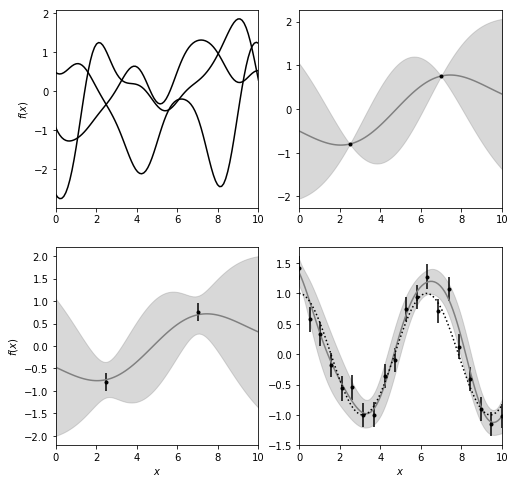

In [7]:
# Ivezic, Figure 8.10
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcess
#from sklearn.gaussian_process import GaussianProcessRegressor

#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)  # Change this to change the number of Gaussians
h = 1.0

#Draw three random gaussian processes (in this case sums of 10 equally spaced Gaussians)
#to illustrate how gaussian processes work.  Both here and in the formal call below the
#error distribution is a squared exponential
mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
gp1 = GaussianProcess(corr='squared_exponential', theta0=0.5, random_state=0)
#gp1 = GaussianProcessRegressor(random_state=0)
gp1.fit(x1[:, None], y1)
f1, MSE1 = gp1.predict(x[:, None], eval_MSE=True)
f1_err = np.sqrt(MSE1)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget" can be specified.  The diagonal of the
#  assumed covariance matrix is multiplied by the nugget.  This is
#  how the error on inputs is incorporated into the calculation
dy2 = 0.2
gp2 = GaussianProcess(corr='squared_exponential', theta0=0.5, nugget=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, MSE2 = gp2.predict(x[:, None], eval_MSE=True)
f2_err = np.sqrt(MSE2)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)
gp3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      thetaL=0.01, thetaU=10.0,
                      nugget=(dy3 / y3) ** 2,
                      random_state=0)
gp3.fit(x3[:, None], y3)
f3, MSE3 = gp3.predict(x[:, None], eval_MSE=True)
f3_err = np.sqrt(MSE3)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta (bandwidth)=", gp3.theta_[0])


#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(8, 8))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

For GP regression we want to estimate the value and variance of a new set of points given an input data set. This is equivalent to averaging over all functions that pass through our input data

The covariance matrix

> $  K = \begin{pmatrix}
    K_{11} & K_{12} \\
    K_{12}^T & K_{22}
  \end{pmatrix},
$

where $K_{11}$ is the covariance between the input points $x_i$ with
observational errors $\sigma_i^2$ added in quadrature to the diagonal,
$K_{12}$ is
the cross-covariance between the input points $x_i$ and the unknown points
$x^\ast_j$, and $K_{22}$ is the covariance between the unknown points
$x_j^\ast$.  Then for observed vectors $\vec{x}$ and $\vec{y}$, and a vector
of unknown points $\vec{x}^\ast$, it can be shown that the posterior is given by

>$  p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast) = \mathcal{N}(\vec{\mu}, \Sigma)$

where

>$
\begin{eqnarray}
  \vec{\mu} &=& K_{12} K_{11}^{-1} \vec{y}, \\
  \Sigma &=& K_{22} - K_{12}^TK_{11}^{-1}K_{12}
\end{eqnarray}
$

$\mu_j$ gives the expected value $\bar{f}^\ast_j$ of the result, and
$\Sigma_{jk}$ gives the error covariance between any two unknown points.

_it gives the value and uncertainty of a predicted point_

Note that the physics of the underlying process enters through the assumed
form of the covariance function 

Apparently the "bible" for GP is [Rasmussen and Williams "Gaussian Processes for Machine Learning" (2005)](http://www.gaussianprocess.org/gpml/).

The Scikit-Learn [`GaussianProcess`](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcess.html) implementation looks like:

In [12]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess
X = np.random.random((100,2))
y = np.sin(10*X[:,0] + X[:,1])
gp = GaussianProcess(corr='squared_exponential')
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, eval_MSE=True)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function constant is deprecated; The function constant of regression_models is deprecated in version 0.19.1 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function squared_exponential is deprecated; The function squared_exp

Below we see what GP does for the supernova example that we used last time.   What is great is that not only do you get a fit, you get errors and can tell where the fit is good and where it is poor.

Gaussian Processes are also pretty useful for time-domain data too, so maybe we'll come back to it after next week.

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function constant is deprecated; The function constant of regression_models is deprecated in version 0.19.1 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function squared_exponential is deprecated; The function squared_exp

Optimal bandwidth= 0.18093568075486155


RuntimeError: matplotlib does not support generators as input

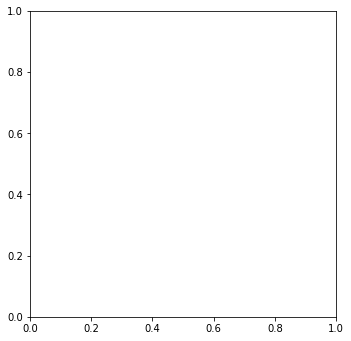

In [13]:
# Ivezic, Figure 8.11
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcess

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-2, thetaU=1,
                     normalize=False,
                     nugget=(dmu / mu_sample) ** 2,
                     random_start=1)
gp.fit(z_sample[:, None], mu_sample)
y_pred, MSE = gp.predict(z_fit[:, None], eval_MSE=True)
sigma = np.sqrt(MSE)
print("Optimal bandwidth=", gp.theta_[0])


#------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

N.B.  In this process we are assuming that the $x$ values are error free.  But really they will have error too.  Ivezic $\S$ 8.8 deals with this, but we are skipping it!

## Over-/Under-Fitting

We already talked a little bit about overfitting, but let's dive down deeper.  We'll use a 1-D model with homoscedastic errors for the sake of illustration, but this discussion applies to more complicated data as well.

To be clear, our data consists of $X_{\rm train}$, $y_{\rm train}$, and $X_{\rm test}$ and we are trying to predict $y_{\rm test}$.  

Let's take an example where
$$0\le x_i \le 3$$
and
$$y_i = x_i \sin(x_i) + \epsilon_i,$$
where the noise, $\epsilon_i$ is given by $\mathscr{N}(0,0.1)$.

In the example below, we draw 20 evenly spaced points from this distribution and fit them with a straight line.

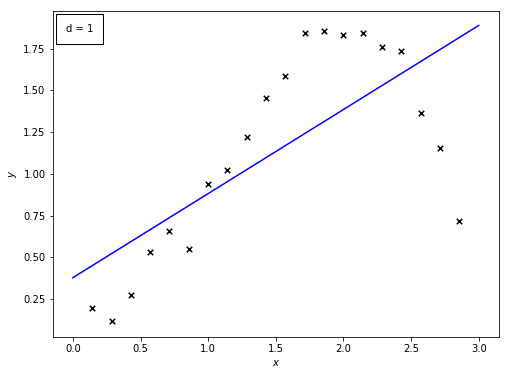

In [14]:
# Ivezic, Figure 8.12
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# First figure: plot points with a linear fit
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(x, y, marker='x', c='k', s=30)

p = np.polyfit(x, y, 1)
y_fit = np.polyval(p, x_fit)

ax.text(0.03, 0.96, "d = 1", transform=plt.gca().transAxes,
        ha='left', va='top',
        bbox=dict(ec='k', fc='w', pad=10))

ax.plot(x_fit, y_fit, '-b')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

This model underfits the data and is said to be "biased" (in the sense that the estimated model parameters deviate significantly from the true model parameters).  

A straight line is a polynomial of order 1, so let's try polynomials of higher order.  Specifically, 2, 3, and all the way up to 19.  We see that 3 is pretty good in that it seems to be relatively unbiased and also lacks the high variance of the order=19 fit (which is also unbiased, but overfit).  So, how do we choose the "right" answer?

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned


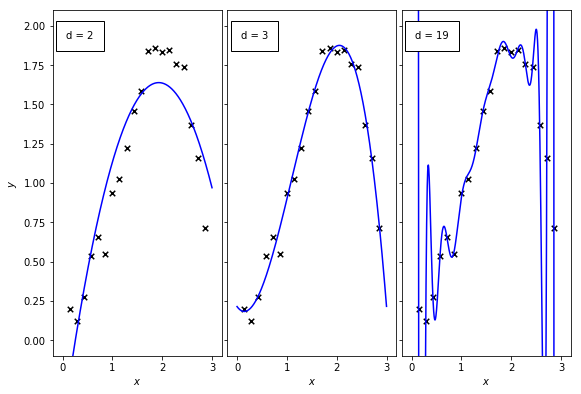

In [15]:
# Ivezic, Figure 8.13
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Second figure: plot fit for several orders of polynomial
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([2, 3, 19]):
    ax = fig.add_subplot(131 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=10))

plt.show()


## Cross-validation

Determining the best trade-off between bias and variance is done through [cross-validation](https://en.wikipedia.org/wiki/Cross-validation).

When we increase the complexity of a model, the data points fit the model more and more closely.   However, this process does not necessarily result in a better fit to the data.  Rather, if the order is too high, then we are *overfitting* the data.  The model has high variance, meaning that a small change in a training point can change the model dramatically.  

We can evaluate this using a training set (50-70% of sample),  a cross-validation set (15-25%) and a test set (15-25%).

The training set is used the determine the model paramters, $\theta_j$.  The training data and cross-validation data then are both used to evaluate the training and cross-validation errors ($\epsilon_{\rm tr}$ and $\epsilon_{\rm CV}$):

$$\epsilon_{\rm cv/tr} = \sqrt{\frac{1}{n}\sum_{i=1}^{N_{\rm cv/tr}}
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]}$$

Why do we need both a training set and a cross-validation set?  Well, because the model parameters, $\theta_j$, are learned from the training set, but the "hyperparameters" (in this case the order) are learned from the cross-validation set.  

The test set then provides the best estimate of the error expected for a new set of data.

We show this graphically in the next figure (Ivezic, 8.14).  For low order both the training and CV error are high--this is sign of a high-bias model that is underfitting the data.  For high order, the training error becomes small (by definition), but the CV error is large.   This is the sign of a high-variance model that is overfitting the data.  It is matching the subtle variations in the training data that aren't really real, and this shows up in the CV analysis.

Similarly we could look at the AIC or BIC which give similiar results.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RankWarning: Polyfit may be poorly conditioned


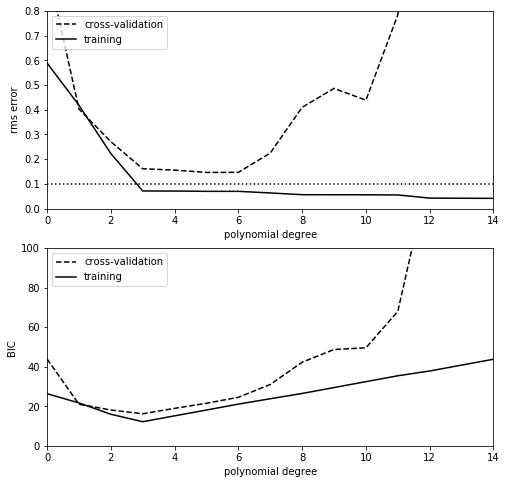

In [16]:
# Ivezic, Figure 8.14
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(8, 8))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)/ len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)/ len(y_cv))

BIC_train = np.sqrt(len(y)) * training_err / dy + d * np.log(len(y))
BIC_crossval = np.sqrt(len(y)) * crossval_err / dy + d * np.log(len(y))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()


Let's look back at our example using the Boston housing data to see how we can make use of *all* of the data in the training using $K$-fold cross validation via `cross_val_predict` from `sklearn.model_selection`.

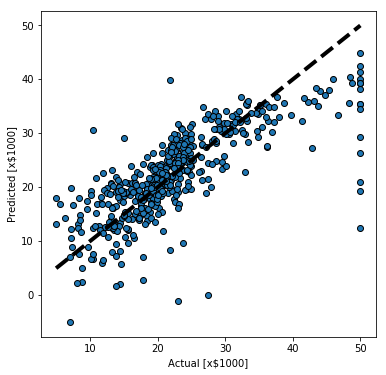

In [17]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

boston = load_boston()
X = boston.data
y = boston.target

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
linreg_scaled = LinearRegression().fit(Xscaled, y)

#Do a 10-fold cross validation
ypred = cross_val_predict(linreg_scaled, X, y, cv=10)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, ypred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual [x$1000]')
ax.set_ylabel('Predicted [x$1000]')
plt.show()

### Learning Curves

We can use a tool called a learning curve to determine if, for a given model, having more training data would help improve the model fits. 

There are two regimes:

1. The training and CV errors have converged.  This indicates that the model is dominated by bias.  In this case increasing the number of training points is futile.
2. The training error is smaller than the CV error.  This indicates that the model is dominated by variance.  In this case, increasing the number of training points may help to improve the model.

In [ ]:
# Ivezic, Figure 8.15
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Fourth figure: plot errors as a function of training set size
np.random.seed(0)
x = 3 * np.random.random(100)
y = func(x)

np.random.seed(1)
x_cv = 3 * np.random.random(100)
y_cv = func(x_cv)

Nrange = np.arange(10, 101, 2)

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.15, top=0.95)

for subplot, d in zip([211, 212], [2, 12]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)

    for j, N in enumerate(Nrange):
        p = np.polyfit(x[:N], y[:N], d)
        training_err[j] = np.sqrt(np.sum((np.polyval(p, x[:N])
                                          - y[:N]) ** 2) / len(y))
        crossval_err[j] = np.sqrt(np.sum((np.polyval(p, x_cv)
                                          - y_cv) ** 2) / len(y_cv))

    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, 0.1 * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w', pad=10))

    ax.set_ylim(0, 0.4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()


In both cases, for small numbers of training points, the difference between the training and CV errors indicates that more data well help.  For the top plot, the convergence of the training and CV errors indicates that adding further data will not reduce the error as it is dominated by *bias*.  A more sophisticated model is needed.